# Exploration of Sentiment Analysis on Movie Reviews

For this exploration, I have explored the effects of AAA on BBB of Movie Reviews. 

Initially I imported and printed the data on the screen. 

In [166]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# thinkstats tool
import thinkstats2
import thinkplot

# numpy, matplotlib, seaborn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# get train & test csv files as a DataFrame
train = pd.read_csv("train.tsv", sep='\t')
test = pd.read_csv("test.tsv", sep='\t')

# drop nan data in train
train = train.dropna()

## Length and sentiment exploration
In the following section, we are going to look at the length of each phrases and the relationship between length and sentiment. 

We will first compute each phrase's length and add a "Length" column to the original data. Then, we will create a dataframe describing the length of each sentiment group, including its mean and standard deviation. Finally, we will plot the mean length value for each sentiment group and analyze whether the differences are statistically significant. 

In [167]:
# functions definition for length data operation
def createLowerWordList(line):
    """
    Given a line of string, seperates 
    the string into lower case word and
    get rid of punctuations and numbers
    """
    # get a splited words list and an empty list
    wordList1 = line.split()
    wordList2 =[]
    # loop through the word list to get rid of punctuations and convert words to lower case
    for word in wordList1:
        cleanWord = ""
        for char in word:
            if char in '!,.?":;0123456789':
                char = ""
            cleanWord += char
        cleanWord = cleanWord.lower()
        if cleanWord != "":
            wordList2.append(cleanWord)
    return wordList2

def add_length(df):
    """
    Generates a length column for given dataset
    to describe each phrase's length
    """
    length = lambda x: len(createLowerWordList(x))
    df['Length'] = df['Phrase'].apply(length)

def get_average_length_sentiment(df):
    """
    create a dataframe by seperating the data by sentiment
    and compute the mean for the length
    """
    dict = {}
    # sentiment_max stores the value of maxium sentiment, which is 4 in this case
    sentiment_max = 4
    # loop through sentiment and compute the length for the data
    # and store its mean and standard deviation to the dictionary
    for i in range(sentiment_max + 1):
        length_series = df[df['Sentiment'] == i]['Length']
        dict[i] = [length_series.mean(), length_series.std()]
    # convert the dictionary to a dataframe
    length_df = pd.DataFrame(dict.items(), columns=['Sentiment', 'Mean_Std'])
    length_df['Mean'] = length_df['Mean_Std'].apply(lambda x: x[0])
    length_df['Std'] = length_df['Mean_Std'].apply(lambda x: x[1])
    return length_df

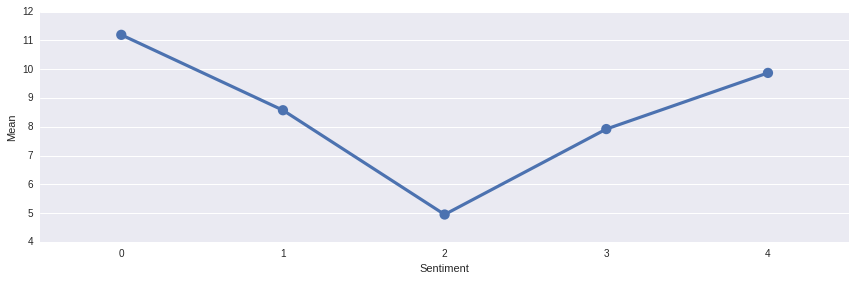

In [168]:
# add Length column to data
add_length(train)
# create a dataframe with analysis of the length data
length_df = get_average_length_sentiment(train)
# factor plot the length versus sentiment
sns.factorplot('Sentiment','Mean', data=length_df,size=4,aspect=3)

<p>
    1. Analyze the significance of these differences
    2. Use the result to interpret our findings 
    3. potential ways of using that data
</p>

## The relationship of phrases within the same sentences
After analyzing the length of sentences, we look at phrases within the same sentence group. We find that sentiments of phrases inside a sentence tend to be similar. 

Thus, we create a new dataframe by seperating phrases by their sentence ID and compute the standard deviation among phrases within same sentences. And then, we seperate the data by sentiment, hoping to see how does the standard deviation varies in different sentiment group. Finally, we compare the standard deviation among these groups to analyze the difference's statistical significance. 

In [253]:
# functions definition for sentence data operation
def sentence_df(df):
    """
    sentence_df() groups phrases with same 
    Sentence Id and returns a dataframe with
    each groups's whole sentence's sentiment,
    the phrases' sentiment's standard deviation
    and variance
    """
    # dictionary to store values collected from sentence group
    sentence_dict = {}
    # loop through dataframes with the same sentence ID
    for i in range(df['SentenceId'].max()):
        # select data with sentence ID i
        select_df = df[df['SentenceId'] == i]
        # internally drop Nan data
        if not select_df.empty:
            # store a list with the structure "[overall_sentiment, variance, standard deviation]"
            sentence_dict[i] = [select_df.iloc[0, 3], select_df['Sentiment'].var(), select_df['Sentiment'].std(), select_df.iloc[0, 4]]
    # convert dictionary to pandas dataframe
    sentence_df = pd.DataFrame(sentence_dict.items(), columns=["Sentence", "Sentiment_Var_Std_Length"])
    
    # split the 'Sentiment_Var_Std' column to 'Sentiment', 'Var', 'Std'
    sentence_df['Sentiment'] = sentence_df['Sentiment_Var_Std_Length'].apply(lambda x: x[0])
    sentence_df['Var'] = sentence_df['Sentiment_Var_Std_Length'].apply(lambda x: x[1])
    sentence_df['Std'] = sentence_df['Sentiment_Var_Std_Length'].apply(lambda x: x[2])
    sentence_df['Length'] = sentence_df['Sentiment_Var_Std_Length'].apply(lambda x: x[3])
        
    return sentence_df.drop('Sentiment_Var_Std_Length', axis=1)

Create a new dataframe by seperating phrases by their sentence ID and compute the standard deviation among phrases within same sentences

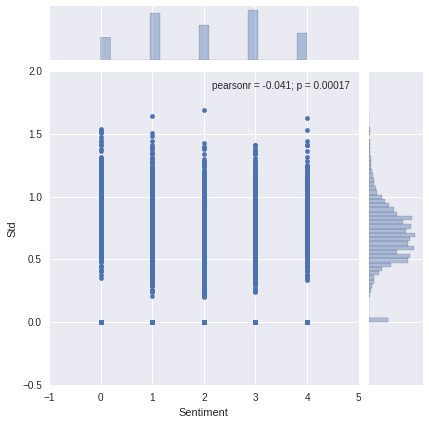

In [254]:
# get a dataframe grouped by sentence ID of train dataset
sentence_df = sentence_df(train)
# plot the joint plot of standard deviation of phases within same sentence ID over sentiments 
sns.jointplot(x="Sentiment", y="Std", data=sentence_df[['Sentiment', 'Std']]);

We can roughly tell that the distribution of each sentiment group is different from each other, but the pattern is very vague and we can hardly tell anything from that graph. In order to verify our hypothesis that the difference between each sentiment group is statistically significant. We further explore the data by seperating the data into different sentiment groups and explore their differences.

While the scatter plot does not provide much information, we learned something from the sentiment's distribution and Std's distribution: 
    
    1. There are more somewhat positive(group 3) and somewhat negative(group 1) than the other groups.    
    2. The distribution of phrases's sentiment standard deviation from its sentence group is at certain level normally distributed while have a cluster around value 0.
    
What we can inferred from these two findings is that:
    
    1. If we find a phrase that has same possibility of being very positive(or negative) and being somewhat positive(or negative), it is safe to guess it is in the group of somewhat since there are about twice phrases in group 1 and 3 than group 0 and 4.    
    2. We need to seperate those sentence group with standard deviation 0 to understand the data. Our guess is that the sentence is relatively short, so that there is not that many phrases to vary from the main sentence.

In [171]:
# seperates the dataframe according to sentiment and sort the data with standard deviation
sentence_zero_df = sentence_df[sentence_df['Sentiment'] == 0].sort_values(['Std'], ascending=True).dropna()
sentence_one_df = sentence_df[sentence_df['Sentiment'] == 1].sort_values(['Std'], ascending=True).dropna()
sentence_two_df = sentence_df[sentence_df['Sentiment'] == 2].sort_values(['Std'], ascending=True).dropna()
sentence_three_df = sentence_df[sentence_df['Sentiment'] == 3].sort_values(['Std'], ascending=True).dropna()
sentence_four_df = sentence_df[sentence_df['Sentiment'] == 4].sort_values(['Std'], ascending=True).dropna()

After seperating the sentence's data, now we can plot the distribution of standard deviation of each sentiment group. In order to make it less confusing, we will first compare group 0, 1, 2; then 2, 3, 4; then 0, 4; then 1, 3. You will see the reason for that throughout the analysis.

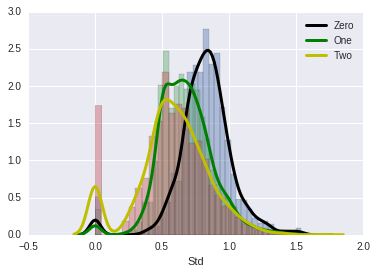

In [172]:
# We first compute draw the distribution of group 0, 1, 2
sns.distplot(sentence_zero_df['Std'], kde_kws={"color": "k", "lw": 3, "label": "Zero"})
sns.distplot(sentence_one_df['Std'], kde_kws={"color": "g", "lw": 3, "label": "One"})
sns.distplot(sentence_two_df['Std'], kde_kws={"color": "y", "lw": 3, "label": "Two"})

We can see from the graph that there seems to have a statistically significant difference among these groups. To comfirm our hypothesis, we will perform the same statistics analysis method we used before over these groups.

In [173]:
# analyze the statistical significance among group 0, 1, 2

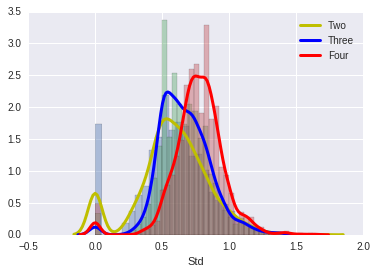

In [174]:
# compare group 2, 3, 4
sns.distplot(sentence_two_df['Std'], kde_kws={"color": "y", "lw": 3, "label": "Two"})
sns.distplot(sentence_three_df['Std'], kde_kws={"color": "b", "lw": 3, "label": "Three"})
sns.distplot(sentence_four_df['Std'], kde_kws={"color": "r", "lw": 3, "label": "Four"})

Similary, we will perform the same statistics analysis method we used before over these groups.

In [175]:
# analyze the statistical significance among group 2, 3, 4

If we compare this graph with the one we created above(comparison among 0, 1, 2), we will find that the result are very similar: phrases within a sentence of strong emotions(group 0 and 4) tends to have statistically significantly greater variance than the group with weaker emotions(group 1, 2, 3), and there is some differences between netrual and the somewhat groups(1 and 3) but not as great as the strong emtion groups. 

To take a closer look at the difference between same emtion level groups, we will plot group 0 against group 4 and group 1 against 3

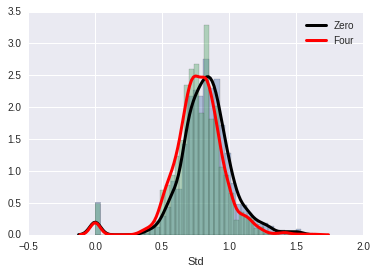

In [176]:
# compare group 0, 4
sns.distplot(sentence_zero_df['Std'], kde_kws={"color": "k", "lw": 3, "label": "Zero"})
sns.distplot(sentence_four_df['Std'], kde_kws={"color": "r", "lw": 3, "label": "Four"})

In [177]:
# analyze the statistical significance among group 0, 4

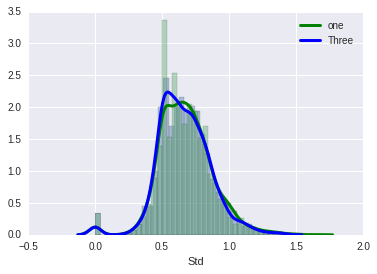

In [178]:
# compare group 1, 3
sns.distplot(sentence_one_df['Std'], kde_kws={"color": "g", "lw": 3, "label": "one"})
sns.distplot(sentence_three_df['Std'], kde_kws={"color": "b", "lw": 3, "label": "Three"})

In [179]:
# analyze the statistical significance among group 1, 3

Now we need to seperate those sentence group with standard deviation 0 to understand the data. Our guess is that the sentence is relatively short, so that there is not that many phrases to vary from the main sentence.

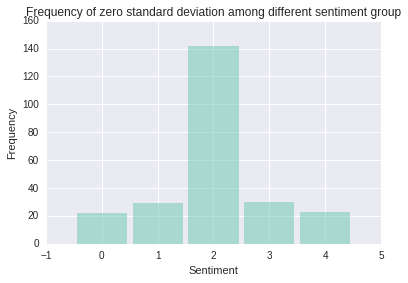

In [180]:
std_zero_df = sentence_df[sentence_df['Std'] == 0]
hist = thinkstats2.Hist(std_zero_df['Sentiment'])
thinkplot.Hist(hist)
thinkplot.Config(xlabel="Sentiment",
                 ylabel="Frequency",
                 title="Frequency of zero standard deviation among different sentiment group")

We can learn from the graph that there is great amount of zero std netural sentiment sentences, and there is not a significant difference among the rest of the groups.

Now we can go and confirm our guess that sentence group with 0 in std should be relatively short in length. To do that, we will first plot the overall Std against Length. And then further explore that relationship in each sentiment groups

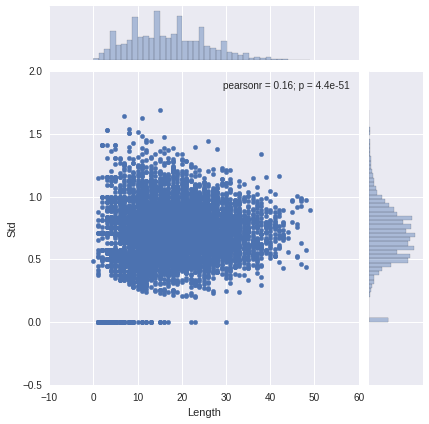

In [256]:
sns.jointplot(x="Length", y="Std", data=sentence_df[['Length', 'Std']]);

The scatter plot is a little bit unclear, but we can see that its center is toward left. And if we look at the distribution of length, we will find the distribution is at some level positively skewed.

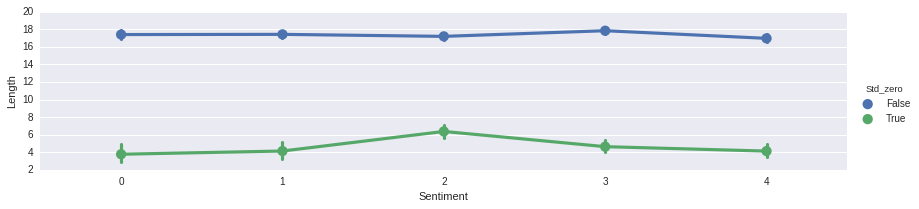

In [263]:
# plot factor plot of Length and sentiment for std value 0 and std value not 0 group

# new boolean column to indicate sentences that has 0 standard deviation
sentence_df['Std_zero'] = sentence_df['Std'] == 0
sns.factorplot('Sentiment','Length', hue='Std_zero', data=sentence_df.sort_values(['Sentiment'], ascending=True), size=3, aspect=4)

<p>
    1. Analyze the significance of these differences 
    2. Use the result to interpret our findings 
    3. potential ways of using that data
</p>

In [264]:
def sentiment_std_zero_length_plot(sentiment):
    """
    takes a given sentiment value, plot the distribution
    of length of std_0 group against std_non_0 group of 
    the given sentiment value group
    """
    # distibution plot of std_0 group
    sns.distplot(sentence_df[(sentence_df['Sentiment'] == sentiment) & (sentence_df['Std_zero'] == True)].Length, 
                 kde_kws={"color": "g", "lw": 3, "label": "Std_zero"})
    # distibution plot of std_non_0 group
    sns.distplot(sentence_df[(sentence_df['Sentiment'] == sentiment) & (sentence_df['Std_zero'] == False)].Length, 
                 kde_kws={"color": "r", "lw": 3, "label": "Std_non_zero"})

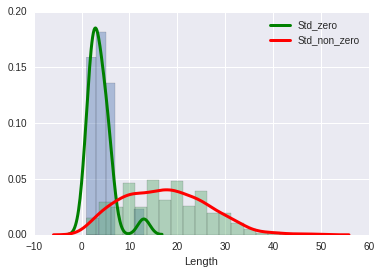

In [265]:
sentiment_std_zero_length_plot(0)

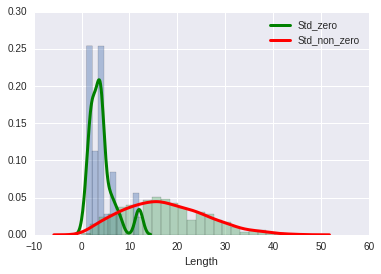

In [266]:
sentiment_std_zero_length_plot(1)

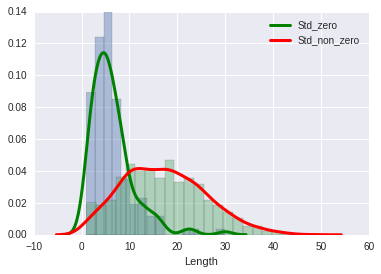

In [267]:
sentiment_std_zero_length_plot(2)

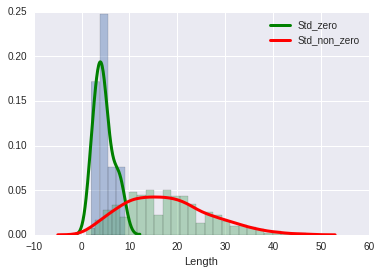

In [268]:
sentiment_std_zero_length_plot(3)

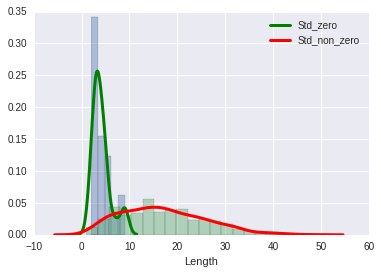

In [270]:
sentiment_std_zero_length_plot(4)

From the above five ditribution plot of the five sentiment groups, we can see that std_0 group and std_non_0 group do have a significant difference in length. We can also find that zero standard deviation values ranges from 1 to 10 in each group. 

If we combine that information with our original data, in other word, if we plot the distribution of sentences length smaller than 10 of each sentiment group's and find them to be relatively low standard deviation, we can get a very useful tool to estimate the sentiment of each phrase within a short sentence.

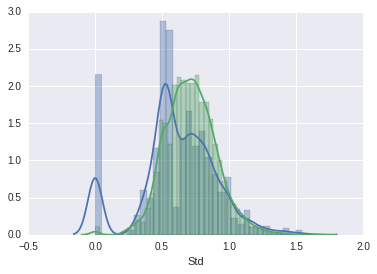

In [292]:
sns.distplot(sentence_df[(sentence_df['Length'] <= 10)].dropna()['Std'])
sns.distplot(sentence_df[(sentence_df['Length'] > 10)].dropna()['Std'])

There is some difference between these two groups. To verify whether it is statistically significant, we will use the same tool to compare them.

<p>
    1. why do we want to look at word
    2. how do we do it overall
</p>

In [182]:
def word_df(df):
    word_dict = {}
    for index, row in df.iterrows():
        list = createLowerWordList(row["Phrase"])
        sentiment = row["Sentiment"]
        
        for word in list:
            if word in word_dict:
                word_dict[word][0] += 1
                word_dict[word][1].append(sentiment)
            else:
                word_dict[word] = [1, [sentiment]]
    
    word_df = pd.DataFrame(word_dict.items(), columns=["Word", "Frequency-Sentiment"])
    word_df['Frequency'] = word_df['Frequency-Sentiment'].apply(lambda x: x[0])
    word_df['Sentiment'] = word_df['Frequency-Sentiment'].apply(lambda x: np.mean(x[1]))
    word_df['Std'] = word_df['Frequency-Sentiment'].apply(lambda x: float(np.std(x[1])))
    return word_df.drop('Frequency-Sentiment', 1).dropna().sort_values(['Frequency'], ascending=False)

<p>
    1. cut the frequency (articulate reasons for that)
    2. choose the sentiment range (articulate reasons for that)
    3. std (articulate reasons for that)
    4. create a word list and show potential ways to use it
    5. compare it to result in the discussion form
</p>

In [183]:
word_df = word_df(train)

64.89057135850908

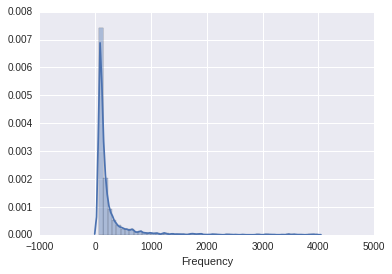

In [184]:
sns.distplot(word_df[(word_df['Frequency'] > 64) & (word_df['Frequency'] < 4700)].Frequency);
word_df['Frequency'].mean()

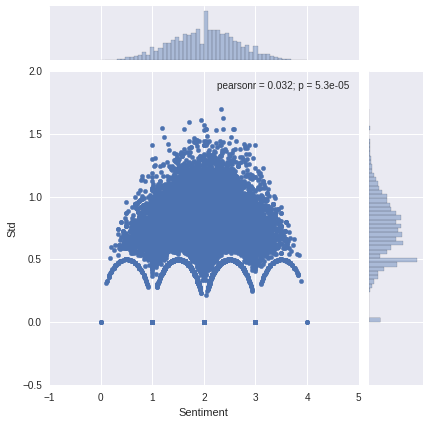

In [185]:
sns.jointplot(word_df['Sentiment'], word_df['Std']);